# Assignment 2: Segmentation from Superpixels

Name: **Jayesh Jayashankar**

UID:  **117450101**

Link to Google Drive : **https://colab.research.google.com/drive/1xL86zMhDYUXm7leNkeJTwYugeLGKcGRT?usp=sharing**

Please submit a PDF containing all outputs to gradescope by **November 30, 3:30pm**




The goal of assignment 2 is to build a segmentation network, which uses SLIC Superpixels as input. In essense, it will be a classifier for superpixels. The end product is a system which, when given an image, computes superpixels and classifies each superpixel as one of the 9 classes of MSRC v1. 

From assignment 1, we already know why SLIC works differently from K-means and how to implement SLIC from scratch. 

This assignment is quite oepn-ended, i.e. we can realize the goal by at least two approaches, 
1. Rescaling every superpixels into 224X224 using resize functions. 
2. Borrow the idea of RoI pooling from Faster-RCNN object detector and use the roi_pool method in PyTorch.

Also, you are welcome to solve the assignment by other approaches as well. 



Here, we provide some ideas of the first method, which is reformulating the Superpixels semantic segmentation problem into an easier problem of image classification. There are basically three steps in the training stage. 

1. Dilate and save each superpixel region from SLIC output into image of size 224X224, alongwith the ground truth segments label. 
2. Build a couple of convolution layers to extract the deep features from each Superpixel patch image. Let the last layer be Fully connected layers.
3. Define the segmentation loss as multi-class classification loss and train a convolutional neural network based classifier.
4. During inference, we combine the classifier's predicted labels to form the whole input image's Superpixel segmentation results.

## Data
First, we download the MSRC labeled imaged database.

In [ ]:
!wget http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
!unzip --qq msrc_objcategimagedatabase_v1.zip

--2021-11-30 13:56:08--  http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.46.196.215, 2600:1407:3c00:108c::e59, 2600:1407:3c00:10a2::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.46.196.215|:80... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip [following]
--2021-11-30 13:56:08--  https://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip
Connecting to download.microsoft.com (download.microsoft.com)|23.46.196.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44119839 (42M) [application/octet-stream]
Saving to: ‘msrc_objcategimagedatabase_v1.zip’

msrc_objcategimaged 100%[===================>]  42.08M 

We provide the following functions as helpers for plotting your results. Please pay attention to their signatures and outputs.

In [ ]:
#All important functions to plot, same as assignment 1
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def plot_image(im,title,xticks=[],yticks= [],cv2 = True):
    """
    im :Image to plot
    title : Title of image 
    xticks : List of tick values. Defaults to nothing
    yticks :List of tick values. Defaults to nothing 
    cv2 :Is the image cv2 image? cv2 images are BGR instead of RGB. Default True
    """
    plt.figure()
    plt.imshow(im[:,:,::-1])
    plt.title(title)
    plt.xticks(xticks)
    plt.yticks(yticks)

def superpixel_plot(im,seg,title = "Superpixels"):
    """
    Given an image (nXmX3) and pixelwise class mat (nXm), 
    1. Consider each class as a superpixel
    2. Calculate mean superpixel value for each class
    3. Replace the RGB value of each pixel in a class with the mean value  
    
    Inputs:
    im: Input image
    seg: Segmentation map
    title: Title of the plot 
    
    Output: None
    Creates a plot    
    """
    clust = np.unique(seg)
    mapper_dict = {i: im[seg == i].mean(axis = 0)/255. for i in clust}

    seg_img =  np.zeros((seg.shape[0],seg.shape[1],3))
    for i in clust:
        seg_img[seg == i] = mapper_dict[i]
    
    plot_image(seg_img,title)
    
    return     

Before you start to build a deep learning model, it is always advised for you to visualize and get familar with the images/segmentations in the dataset.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  # Remove the CWD from sys.path while we load stuff.


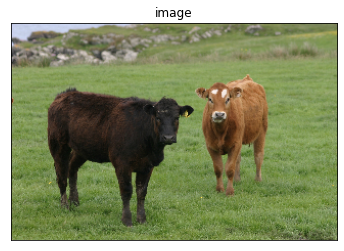

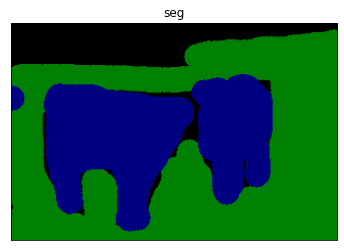

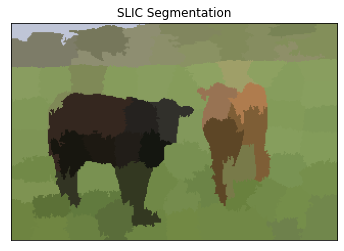

In [ ]:
#  plot a sample image and its ground truth segments
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s.bmp')
seg_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_19_s_GT.bmp')
plot_image(image_sample, 'image')
plot_image(seg_sample, 'seg')

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")

In [ ]:
import cv2
from skimage.segmentation import slic
from IPython import embed
import os

from tqdm import tqdm
import pandas as pd

current_directory = os.getcwd()
msrc_directory = current_directory + '/MSRC_ObjCategImageDatabase_v1'

In [ ]:
#Superpixel dataset preparation

# from Dataset_v1
SEG_LABELS_LIST_v1 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 5,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 6, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 7, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 8, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": -1, "name": "horse",       "rgb_values": [128,   0,    128]},
    {"id": -1, "name": "water",       "rgb_values": [64,   128,    0]},
    {"id": -1, "name": "mountain",       "rgb_values": [64,   0,    0]},
    {"id": -1, "name": "sheep",       "rgb_values": [0,   128,    128]}]

# from Dataset_v2
SEG_LABELS_LIST_v2 = [
    {"id": -1, "name": "void",       "rgb_values": [0,   0,    0]},
    {"id": 0,  "name": "building",   "rgb_values": [128, 0,    0]},
    {"id": 1,  "name": "grass",      "rgb_values": [0,   128,  0]},
    {"id": 2,  "name": "tree",       "rgb_values": [128, 128,  0]},
    {"id": 3,  "name": "cow",        "rgb_values": [0,   0,    128]},
    {"id": 4,  "name": "horse",      "rgb_values": [128, 0,    128]},
    {"id": 5,  "name": "sheep",      "rgb_values": [0,   128,  128]},
    {"id": 6,  "name": "sky",        "rgb_values": [128, 128,  128]},
    {"id": 7,  "name": "mountain",   "rgb_values": [64,  0,    0]},
    {"id": 8,  "name": "airplane",   "rgb_values": [192, 0,    0]},
    {"id": 9,  "name": "water",      "rgb_values": [64,  128,  0]},
    {"id": 10, "name": "face",       "rgb_values": [192, 128,  0]},
    {"id": 11, "name": "car",        "rgb_values": [64,  0,    128]},
    {"id": 12, "name": "bicycle",    "rgb_values": [192, 0,    128]},
    {"id": 13, "name": "flower",     "rgb_values": [64,  128,  128]},
    {"id": 14, "name": "sign",       "rgb_values": [192, 128,  128]},
    {"id": 15, "name": "bird",       "rgb_values": [0,   64,   0]},
    {"id": 16, "name": "book",       "rgb_values": [128, 64,   0]},
    {"id": 17, "name": "chair",      "rgb_values": [0,   192,  0]},
    {"id": 18, "name": "road",       "rgb_values": [128, 64,   128]},
    {"id": 19, "name": "cat",        "rgb_values": [0,   192,  128]},
    {"id": 20, "name": "dog",        "rgb_values": [128, 192,  128]},
    {"id": 21, "name": "body",       "rgb_values": [64,  64,   0]},
    {"id": 22, "name": "boat",       "rgb_values": [192, 64,   0]}]

# create a map rgb_2_label, where mapping the ground truth 3-d array segmentation into a single ID label.
#Also creating label_2_rgb to map class labels to rgb values whes predicting the segmentation on test set
rgb_2_label = {}
label_2_rgb = {}
for i in SEG_LABELS_LIST_v1:
    rgb_2_label[tuple(i['rgb_values'])] = i['id']
    label_2_rgb[i['id']] = i['rgb_values']

## Question 1: Superpixel Dataset (30 points) 

First, we dilate each superpixel and save the output superpixel patch from SLIC into 224X224 size image (after rescaling), alongwith the ground truth segments label. 

For the purpose of consistency, we adopt the existing SLIC implenmentation from the scikit-learn machine learning package.

Suggested algorithm: Save the superpixels along with their segmentation class. You could implement this as follows:

For each image
1. Get superpixels sp_i for image x. We adopt 100 segments in this assignment, 'segments = slic(image, n_segments=100, compactness=10)'.
2. For every superpixel sp_i in the image, \\
    2.1. find the smallest rectangle which can enclose sp_i <br>
    2.2. Dilate the rectangle by 3 pixels.<br>
    2.3. Get the same region from the segmentation image (from the file with similar name with *_GT). The class for this sp_i is mode of segmentation classes in that same region. Save the dilated region as npy (jpg is lossy for such small patches).<br>


Alternatively, you could create a single csv with columns segment patch location, class label for each sp_i of each image.<br>




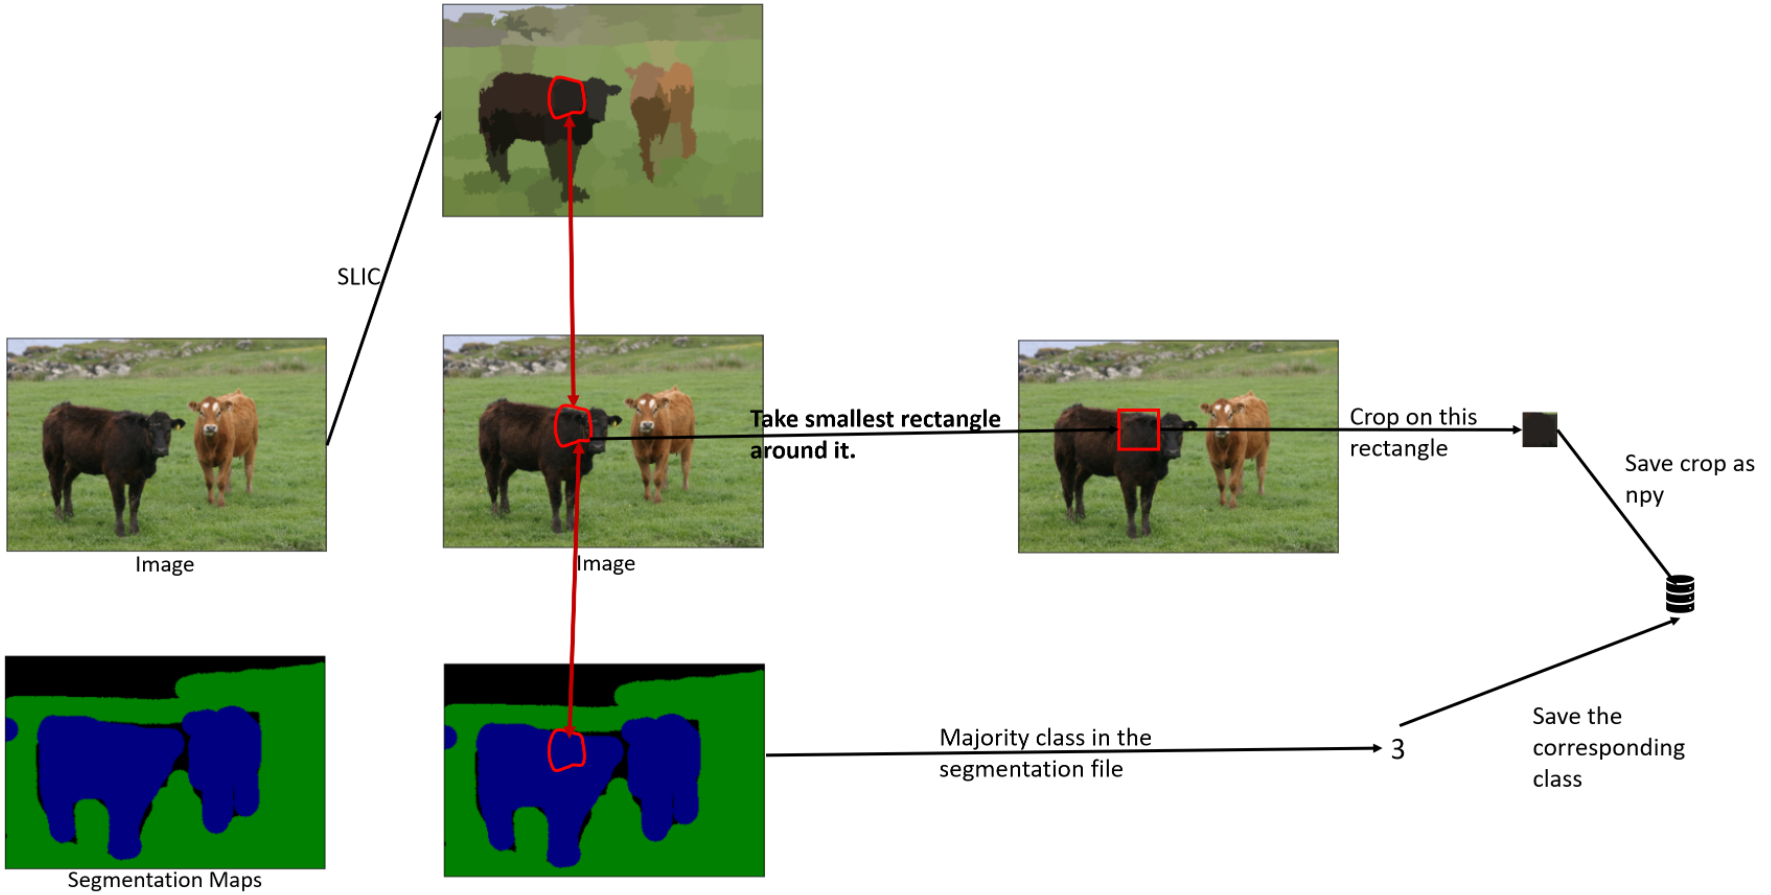

In [ ]:
# run SLIC on each original images and save the (segment patch, ID label) pair
# segments = slic(image, n_segments=100, compactness=10) 
# it may take up to half an hour to process, depending on the hardware resources
# save the output file names to train.txt 
# Alternatively, you don't save the segment patch and ID label offline, instead, 
# you process them on the fly later.

## Create the train, test directories
if os.path.exists('./datasets/train.txt'):
    os.remove('./datasets/train.txt')

if os.path.exists('./datasets/train.txt'):
    os.remove('./datasets/train.txt')


slic_segments = 100
npy='.npy'

#Function to obtain the rectangule coordinates for each superpixel, followed by dilation of each patch by 3 pixels
def get_rect_patch(seg_map, seg_label):
  h, w = seg_map.shape
  seg_label_ind = np.where(seg_map == seg_label)
  if len(seg_label_ind[0]) == 0:
    return None

  y_list = seg_label_ind[0]
  x_list = seg_label_ind[1]
  x_min, x_max = min(x_list), max(x_list)
  y_min, y_max = min(y_list), max(y_list)

  #Dilation of the patch by 3 pixels 
  x_min = max(0, x_min - 3)
  y_min = max(0, y_min - 3)

  x_max = min(w, x_max + 3)
  y_max = min(h, y_max + 3)
  rect_patch = x_min, x_max, y_min, y_max
  #print('rect',rect_patch)
  return rect_patch

#Function to crop the rectangular patch in each superpixel
def crop_image(image, rect_patch_loc):
  x_min, x_max, y_min, y_max = rect_patch_loc
  cropped_image = image[y_min:y_max, x_min:x_max]
  return cropped_image

#Obtaining the segmentation class labelcfor ground truth image
def get_gt_label(gt_img_patch):
  label_count = np.zeros(10)
  h, w = gt_img_patch.shape[:-1]
  for i in range(h):
    for j in range(w):
      color = tuple(gt_img_patch[i,j])
      label = rgb_2_label.get(color, -1)
      label_count[label+1] += 1

  seg_label= np.argmax(label_count)
  return (seg_label) 

#Function to generate the npy file and write to a csv object
def crop_rect(seg_map, img, gt_img, filename, data_loc, csv_recs, text_file):
  for seg in range(1100):
    rect_patch = get_rect_patch(seg_map, seg)
    if rect_patch is not None:
      img_crop = crop_image(img, rect_patch)
      #print('cropped')
      gt_img_crop = crop_image(gt_img, rect_patch)
      #print('cropping')
      seg_class_label = get_gt_label(gt_img_crop)
      
      # now we can save the train_image and the class label
      new_filename = filename.replace('.bmp', (f'_{seg}_{npy}'))
      data_filename_path = os.path.join(data_loc,new_filename)
      
      np.save(data_filename_path, img_crop)
      
      csv_recs.append([new_filename, seg_class_label])
      
      with open(f'{os.path.join(msrc_directory,data_dir)}/{text_file}', 'a+') as textfile:
        textfile.write(new_filename + '\n') 

#Function which calls different functions to create he npy file, write to a csv file and textfile
def data_npy_convert(files, path, csv_file, textfile):
  csv_recs = []  # [image_file_path, label]
  for file in files:
    # Your code
    img_file = file
    gt_file = file.replace('.bmp', ('_GT'+'.bmp'))
    
    img_file = os.path.join(msrc_directory, img_file)
    gt_file = os.path.join(msrc_directory, gt_file)

    img = cv2.imread(img_file)
    gt_img = cv2.imread(gt_file)
    
    img = img[:,:,::-1]   # bgr to rgb
    gt_img = gt_img[:,:,::-1]           # bgr to rgb

    seg_map = slic(img, n_segments=slic_segments, compactness=10)
    crop_rect(seg_map, img, gt_img, file, path, csv_recs, textfile)
    
  imagepath_label = pd.DataFrame(csv_recs, columns=['path_location', 'class_label'])
  imagepath_label.to_csv(f'{path}/{csv_file}')

#Variables to describe the text and csv files
csv_traintext = 'train.txt'
csv_testtext = 'test.txt'
csv_train = 'train.csv'
csv_test = 'test.csv'

#Defining different folders for storing the training and test data
data_dir = 'datasets'
train_dir = 'datasets/train'
test_dir = 'datasets/test'
datasets = os.path.join(msrc_directory, data_dir)
datasets_train = os.path.join(msrc_directory, train_dir)
datasets_test = os.path.join(msrc_directory, test_dir)


if not os.path.exists(os.path.join(msrc_directory,data_dir)):
  os.mkdir(os.path.join(msrc_directory,data_dir))

if not os.path.exists(datasets_train):
  os.mkdir(datasets_train)

if not os.path.exists(datasets_test):
  os.mkdir(datasets_test)

files = os.listdir(msrc_directory)
dataset=[]

#Storing the .bmp files in a list to eventually split into training and test data
for file in files:
  # Your code
  if '.bmp' in file and '_GT' not in file:
    dataset.append(file)

from sklearn.model_selection import train_test_split
#Splitting the data into a training and test set
train_data,test_data = train_test_split(dataset, test_size=0.2, random_state=42)

#Processing the training and test data into npy files and generating a csv file
data_npy_convert(train_data, datasets_train, csv_train, csv_traintext)
print('Training data processed')
print('train',train_data,'\n','test',test_data)
data_npy_convert(test_data, datasets_test, csv_test, csv_testtext)
print('Test data processed')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


Training data processed
train ['3_9_s.bmp', '6_11_s.bmp', '7_3_s.bmp', '3_12_s.bmp', '1_13_s.bmp', '6_12_s.bmp', '3_11_s.bmp', '1_11_s.bmp', '1_12_s.bmp', '1_26_s.bmp', '8_15_s.bmp', '3_1_s.bmp', '8_22_s.bmp', '1_9_s.bmp', '4_24_s.bmp', '5_3_s.bmp', '1_2_s.bmp', '3_27_s.bmp', '3_21_s.bmp', '3_23_s.bmp', '7_26_s.bmp', '1_30_s.bmp', '5_4_s.bmp', '4_7_s.bmp', '4_23_s.bmp', '1_6_s.bmp', '3_6_s.bmp', '7_1_s.bmp', '8_7_s.bmp', '8_26_s.bmp', '7_23_s.bmp', '7_24_s.bmp', '8_5_s.bmp', '3_22_s.bmp', '3_24_s.bmp', '2_20_s.bmp', '5_26_s.bmp', '5_24_s.bmp', '4_1_s.bmp', '8_27_s.bmp', '8_3_s.bmp', '1_20_s.bmp', '5_14_s.bmp', '2_16_s.bmp', '1_25_s.bmp', '5_15_s.bmp', '2_12_s.bmp', '3_29_s.bmp', '1_8_s.bmp', '1_19_s.bmp', '6_28_s.bmp', '3_4_s.bmp', '5_2_s.bmp', '2_7_s.bmp', '5_28_s.bmp', '4_26_s.bmp', '6_2_s.bmp', '6_13_s.bmp', '5_7_s.bmp', '7_16_s.bmp', '2_19_s.bmp', '6_6_s.bmp', '8_10_s.bmp', '2_8_s.bmp', '7_25_s.bmp', '7_12_s.bmp', '6_3_s.bmp', '3_30_s.bmp', '2_18_s.bmp', '5_16_s.bmp', '5_5_s.bmp', 

Now, we can define the dataset and dataloader.

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data as data
from PIL import Image
from torchvision import transforms
import _pickle as pickle
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# -------------
# Dataset class
# -------------
#
# ``torch.utils.data.Dataset`` is an abstract class representing a
# dataset.
# Your custom dataset should inherit ``Dataset`` and override the following
# methods:
#
# -  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
# -  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
#    be used to get sp_i sample
#
# Let's create a dataset class for our superpixel dataset. We will
# read the csv in ``__init__`` but leave the reading of images to
# ``__getitem__``. This is memory efficient because all the images are not
# stored in the memory at once but read as required.
#
# Sample of our dataset will be a dict
# ``{'superpixel image': image, 'superpixel class': class}``. Our dataset will take an
# optional argument ``transform`` so that any required processing can be
# applied on the sample. Remember to resize the image using ``transform``.

class SegmentationData(data.Dataset):
    def __init__(self, data_path, csv_file, transform=None):
      # Your code 
      self.data = pd.read_csv(f'{data_path}/{csv_file}', skiprows=1, header=None) #Reading records from the CSV file
      self.data_size = len(self.data)
      self.data_path = data_path
      self.transform = transform

            
    def __len__(self):
      # Your code 
      return self.data_size

    
    def __getitem__(self, index):
      # Your code 
      filename = self.data.iloc[index, 1] #Path of the npy files
      image_path = f'{self.data_path}/{filename}'
      image = np.load(image_path, allow_pickle=True)
      label_y = int(self.data.iloc[index, 2]) #Class label of the superpixel
      data_y = torch.tensor(label_y)
      if self.transform:
        image = self.transform(image)

      return (image, label_y)


cuda:0


## IMPORTANT

Show some outputs! Choose 1 image. For that image, plot the image, along with the superpixel map for the image, as you did for Assignment 1. Then, show the first 10 superpixel patches for the image, retrieved from your dataset.

The output for this portion will be 12 images, displayed below your code below.

/content/MSRC_ObjCategImageDatabase_v1/datasets/train/1_24_s.bmp


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  # This is added back by InteractiveShellApp.init_path()


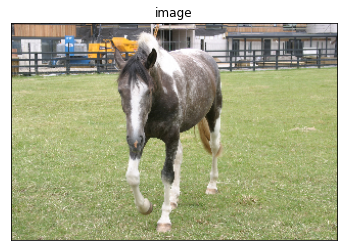

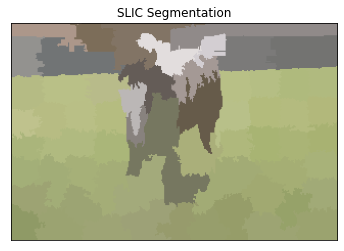

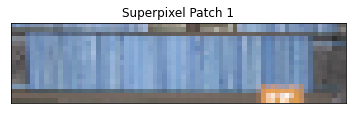

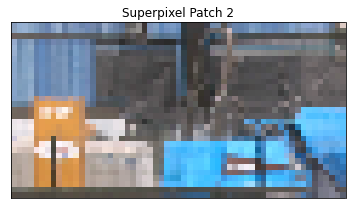

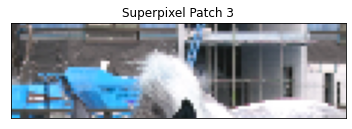

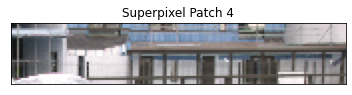

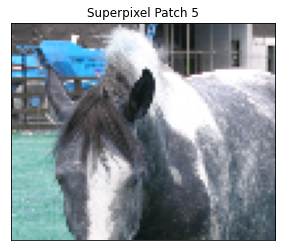

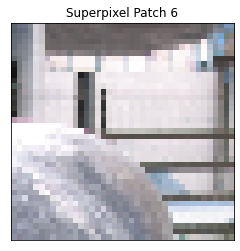

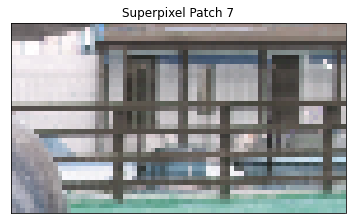

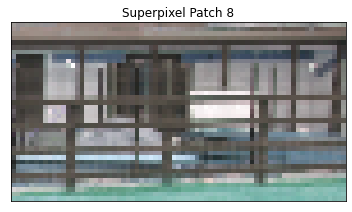

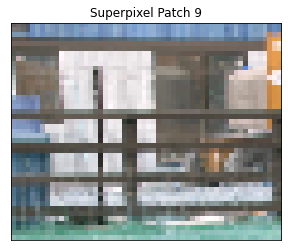

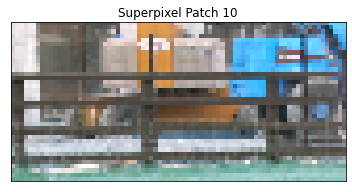

In [ ]:
### YOUR CODE TO PLOT 12 images (GT + superpixel map + first 10 superpixels) ###
image_sample = cv2.imread('MSRC_ObjCategImageDatabase_v1/1_24_s.bmp')
plot_image(image_sample, 'image')
sample_image=os.path.join(msrc_directory,'1_24_s.bmp')
sample_npy=os.path.join(datasets_train,'1_24_s.bmp')
print(sample_npy)

#  run SLIC on the sample image and plot the corresponding SLIC segments
from skimage.segmentation import slic

segments_sample = slic(image_sample, n_segments=100, compactness=10)
superpixel_plot(image_sample, segments_sample, title = "SLIC Segmentation")
datasets_train = os.path.join(msrc_directory, train_dir)

c=1
for i in range(slic_segments):
  if os.path.exists(sample_npy.replace('.bmp', (f'_{i}_{npy}'))):
      image_sample = np.load(sample_npy.replace('.bmp', (f'_{i}_{npy}')))
      if c>10:
        break  
      plot_image(image_sample,'Superpixel Patch %d' % (c))
      c+=1


## Question 2: Deep Network (10 points)

We use a pre-trained network (like VGG) and replace the last few layers with a fully connected layer.

In [ ]:
def custom_vgg16():

  # load the pre-trained model
  vgg16 = models.vgg16(pretrained=True) 
  
  # freeze convolution weights
  for param in vgg16.features.parameters():
    param.requires_grad = False

  inputs = vgg16.classifier[6].in_features
  outputs = 10    #10 segmentation classes
  vgg16.classifier[6] = nn.Sequential(
                        nn.Linear(inputs, 1024), 
                        nn.ReLU(inplace=True), 
                        nn.Linear(1024, outputs))
  
  
  return vgg16


# Model definition
class SegmentationNN(nn.Module):
    def __init__(self):  
      # Your code 
      super(SegmentationNN, self).__init__()
      
      # load the pre-trained model
      self.model = custom_vgg16()
      self.model.to(device)
      print(self.model)
      
    def forward(self, x):
      # Your code 
      x = self.model(x)
      return x


## Question 3: Optimizer (10 points) 

Finally, we define the classification loss and optimizer such that we can learn a superpixel classifier from the backproporgation algorithm. 

In [ ]:
import time
from torch.autograd import Variable

# hyperparams
num_epochs = 5
LEARNING_RATE = 1e-4

# Optimizer 
class Solver(object):
    def __init__(self, model, learning_rate=LEARNING_RATE):
      # Your code 
      # pass
      self.model = model
      self.criterion = nn.CrossEntropyLoss()
      self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      
      # Define Scheduler
      self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.1, patience=10, verbose=True
      )
      self.epoch_acc = []
      self.epoch_loss = []
      self.running_loss = []
      self.running_acc = []
    
    def train1(self, data_loader):
      best_accuracy = 0.0
      # Define your execution device
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("The model will be running on", device, "device")

      # Convert model parameters and buffers to CPU or Cuda
      model.to(device)
      model.train()
      for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        acc1 = 0.0
        total=0.0
        accuracy=0.0
        losses=[]
        for i, (images, labels) in enumerate(data_loader, 0):
            
            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # predict classes using images from the training set
            outputs = model(images)

            _, preds = torch.max(outputs, 1)
            loss = self.criterion(outputs, labels)

            losses.append(loss.item())
            accuracy += torch.sum(preds == labels)

            total += outputs.size(0)
            # compute the loss based on model output and real labels


            # zero the parameter gradients
            self.optimizer.zero_grad()

            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            self.optimizer.step()

        avg_loss=sum(losses)/len(losses)
        print('Epoch:',epoch + 1,',','Average Loss:',avg_loss)

        self.scheduler.step(avg_loss)

        acc1 = (100*accuracy / total)
        print('For epoch', epoch+1,'Accuracy %d %%' % (acc1))

    def test(self, data_loader):
      # Define your execution device
      device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      print("The model will be running on", device, "device")

      # Convert model parameters and buffers to CPU or Cuda
      model.to(device)
      model.eval()
      for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        acc1 = 0.0
        total=0.0
        accuracy=0.0
        for i, (images, labels) in enumerate(data_loader, 0):
            
            # get the inputs
            images = images.to(device)
            labels = labels.to(device)

            # predict classes using images from the training set
            outputs = model(images)

            _, preds = torch.max(outputs, 1)

            accuracy += torch.sum(preds == labels)

            total += outputs.size(0)
            # compute the loss based on model output and real labels
            #loss = self.criterion(outputs, labels)
            # backpropagate the loss
            #loss.backward()
            # adjust parameters based on the calculated gradients
            #self.optimizer.step()
            '''
            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
            if i % 200 == 199:    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 200))
                # zero the loss
                running_loss = 0.0
            '''
        acc1 = (100*accuracy / total)
        print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (acc1))


## Question 4: Putting it together (50 points) 

Start to train your network and observe the loss in time.
During the inference stage, combine the SLIC Superpixels' predicted labels to form the whole input image's Superpixel segmentation results.

1. Randomly split the whole dataset into train and test subset (80:20 split is fine), show us the training loss of the classifier after every epoch, and then training accuracy and test accuracy of the classifier after training.
2. At least one visualization on the test segmentation map vs. ground truth segmentation map.

In [ ]:
#Dataset has already been randomnly split into a train and test_set, the images are reshaped into 224x224 before training

#Transforms component to reshape image to 224x224 tensor
transforms = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224, 224]),
        transforms.ToTensor()
        ])

# load the data
train_dataset = SegmentationData(datasets_train, csv_train, transforms)
test_dataset = SegmentationData(datasets_test, csv_test, transforms)


# data loader
train_data_loader = data.DataLoader(dataset=train_dataset, batch_size=16, shuffle=True, num_workers=2)
test_data_loader = data.DataLoader(dataset=test_dataset, batch_size=16, shuffle=True, num_workers=2)

#verify the shape of the tensor which is ([3x224x224])
dataiter = iter(test_data_loader)
dataiter_next = dataiter.next()
print(dataiter_next[0][0].shape)


torch.Size([3, 224, 224])


In [ ]:
# model
model = SegmentationNN()

#Training the model
solver = Solver(model, LEARNING_RATE)
solver.train1(train_data_loader)
print('Training Completed')

#Saving and Loading the model
torch.save(model.state_dict(), 'checkpoint.pth')
model.load_state_dict(torch.load('/content/checkpoint.pth'))


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#Validating accuracy on test data
solver.test(test_data_loader)
print('Evaluation on test set completed')

The model will be running on cuda:0 device
For epoch 1 the test accuracy over the whole test set is 75 %
For epoch 2 the test accuracy over the whole test set is 75 %
For epoch 3 the test accuracy over the whole test set is 75 %
For epoch 4 the test accuracy over the whole test set is 75 %
For epoch 5 the test accuracy over the whole test set is 75 %
Evaluation on test set completed


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  from ipykernel import kernelapp as app
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


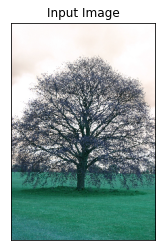

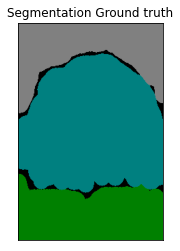

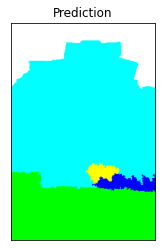

In [ ]:
filename = test_data[10] #Random image selected from the test set
test_sample_filename = filename
test_gt_filename = filename.replace('.bmp', '_GT'+'.bmp')

dataset = os.path.join(msrc_directory, data_dir)
test_file= os.path.join(msrc_directory, filename)
test_gt_file = os.path.join(msrc_directory, test_gt_filename)

test_image = cv2.imread(test_file)
test_gt_image = cv2.imread(test_gt_file)

test_image = test_image[:,:,::-1]   # bgr to rgb
test_gt_image = test_gt_image[:,:,::-1]           # bgr to rgb

seg_map = slic(test_image, n_segments=slic_segments, compactness=10)
slic_label_to_seg_class_map = {}
predicted_img = np.zeros(test_image.shape)

#Function to obtain the superpixel patch from the selected image
def get_image_patch(seg_map, seg_label, image):
  rect_patch = get_rect_patch(seg_map, seg_label)
  if rect_patch is not None:
    img_patch = crop_image(image, rect_patch)
    return img_patch
  else:
    return None

model.eval()
for i in range(slic_segments):
  
  image_patch = get_image_patch(seg_map, i, test_image)

  if image_patch is not None:
    image_patch = transforms(image_patch).to(device)
    image_patch  = image_patch .unsqueeze(0) 
    predictions = model(image_patch)

    _, preds = torch.max(predictions, 1)

    ind = (seg_map == i)
    #Predicting the rgb pixels based on the superpixel class
    predicted_img[ind] = label_2_rgb[preds.item()-1]
  else:
    break

plot_image(test_image,'Input Image')
plot_image(test_gt_image,'Segmentation Ground truth')
plot_image(predicted_img,'Prediction')

## Bonus Questions (20 points):

IMPORTANT: No matter which option you choose, you can earn a maximum of 20 points for this section.

We always want to increase the classifier accuracy and achieve a better performance by building a complicated deep learning model. There are a lot of tricks which are very popular and work in practice. Try to implement either of following two,

1. Could you effictively fuse different deep features from multiple layers in your network? You are welcome to use the pretrained network. Does your network achieve a better accuracy? There are a lot of exploration in the literature, including ION (Inside-Outside Net) [1], Hypercolumns [2], and PixelNet [3]. The following figure illustrates ION architecture combining features from different layers. Can you do similar thing for our Superpixel classifier?

2. Could you build a Multi-resolution network to explore the effectiveness of the multi-scale on the task of Superpixels segmentation? By multi-scale, we mean multiple resolutions of superpixels. See [4] for an example.

[1] Inside-Outside Net: Detecting Objects in Context with Skip Pooling and Recurrent Neural Networks

[2] Hypercolumns for Object Segmentation and Fine-grained Localization

[3] PixelNet: Representationofthe pixels, by the pixels, and for the pixels

[4] Feedforward semantic segmentation with zoom-out features

In [ ]:
#TODO: Bonus

